In [ ]:
pip install faiss-gpu

     |████████████████████████████████| 89.4MB 60kB/s 


**Imports**

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import math
import faiss
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch.utils.data.sampler import Sampler
import pickle

torch.manual_seed(31)
torch.cuda.manual_seed_all(31)
np.random.seed(31)

**Samplers**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class UnifLabelSampler(Sampler):
    """Samples elements uniformely accross pseudolabels.
        Args:
            N (int): size of returned iterator.
            images_lists: dict of key (target), value (list of data with this target)
    """

    def __init__(self, N, images_lists):
        self.N = N
        self.images_lists = images_lists
        self.indexes = self.generate_indexes_epoch()

    def generate_indexes_epoch(self):
        nmb_non_empty_clusters = 0
        for i in range(len(self.images_lists)):
            if len(self.images_lists[i]) != 0:
                nmb_non_empty_clusters += 1

        size_per_pseudolabel = int(self.N / nmb_non_empty_clusters) + 1
        res = np.array([])

        for i in range(len(self.images_lists)):
            # skip empty clusters
            if len(self.images_lists[i]) == 0:
                continue
            indexes = np.random.choice(
                self.images_lists[i],
                size_per_pseudolabel,
                replace=(len(self.images_lists[i]) <= size_per_pseudolabel)
            )
            res = np.concatenate((res, indexes))

        np.random.shuffle(res)
        res = list(res.astype('int'))
        if len(res) >= self.N:
            return res[:self.N]
        res += res[: (self.N - len(res))]
        return res

    def __iter__(self):
        return iter(self.indexes)

    def __len__(self):
        return len(self.indexes)

**Kmeans**

In [ ]:
class ReassignedDataset(data.Dataset):
    """A dataset where the new images labels are given in argument.
    Args:
        image_indexes (list): list of data indexes
        pseudolabels (list): list of labels for each data
        dataset (list): list of tuples with paths to images
        transform (callable, optional): a function/transform that takes in
                                        an PIL image and returns a
                                        transformed version
    """

    def __init__(self, image_indexes, pseudolabels, dataset, transform=None):
        self.imgs = self.make_dataset(image_indexes, pseudolabels, dataset)
        self.transform = transform

    def make_dataset(self, image_indexes, pseudolabels, dataset):
        #print('Make Dataset')
        label_to_idx = {label: idx for idx, label in enumerate(set(pseudolabels))}
        images = []
        for j, idx in enumerate(image_indexes):
            path = dataset[idx][0]
            pseudolabel = label_to_idx[pseudolabels[j]]
            images.append((path, pseudolabel))
        return images

    def __getitem__(self, index):
        """
        Args:
            index (int): index of data
        Returns:
            tuple: (image, pseudolabel) where pseudolabel is the cluster of index datapoint
        """
        path, pseudolabel = self.imgs[index]
        img = pil_loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, pseudolabel

    def __len__(self):
        return len(self.imgs)


def cluster_assign(images_lists, dataset):
    """Creates a dataset from clustering, with clusters as labels.
    Args:
        images_lists (list of list): for each cluster, the list of image indexes
                                    belonging to this cluster
        dataset (list): initial dataset
    Returns:
        ReassignedDataset(torch.utils.data.Dataset): a dataset with clusters as
                                                     labels
    """
    assert images_lists is not None
    pseudolabels = []
    image_indexes = []

    #print('Assigning CLusters')
    for cluster, images in enumerate(images_lists):
        image_indexes.extend(images)
        pseudolabels.extend([cluster] * len(images))

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    t = transforms.Compose([transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            normalize])

    return ReassignedDataset(image_indexes, pseudolabels, dataset, t)



def preprocess_features(npdata, pca=256):
    """Preprocess an array of features.
    Args:
        npdata (np.array N * ndim): features to preprocess
        pca (int): dim of output
    Returns:
        np.array of dim N * pca: data PCA-reduced, whitened and L2-normalized
    """
    _, ndim = npdata.shape
    npdata =  npdata.astype('float32')

    #Apply PCA-whitening with Faiss
    #print('PCA')
    # mat = faiss.PCAMatrix (ndim, pca, eigen_power=-0.5)
    # mat.train(npdata)
    # assert mat.is_trained
    # npdata = mat.apply_py(npdata)

    # L2 normalization
    row_sums = np.linalg.norm(npdata, axis=1)
    npdata = npdata / row_sums[:, np.newaxis]

    return npdata



def run_kmeans(x, nmb_clusters, verbose=True):
    """Runs kmeans on 1 GPU.
    Args:
        x: data
        nmb_clusters (int): number of clusters
    Returns:
        list: ids of data in each cluster
    """
    n_data, d = x.shape

    # faiss implementation of k-means
    clus = faiss.Clustering(d, nmb_clusters)

    # Change faiss seed at each k-means so that the randomly picked
    # initialization centroids do not correspond to the same feature ids
    # from an epoch to another.
    clus.seed = np.random.randint(1234)

    clus.niter = 20
    clus.max_points_per_centroid = 10000000
    res = faiss.StandardGpuResources()
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.useFloat16 = False
    flat_config.device = 0
    index = faiss.GpuIndexFlatL2(res, d, flat_config)

    # perform the training
    #print('Cluster Training')
    clus.train(x, index)
    _, I = index.search(x, 1)

    #print('Cluster Lose ')
    stats = clus.iteration_stats
    losses = np.array([
        stats.at(i).obj for i in range(stats.size())
    ])
    
    #print('k-means loss evolution: {0}'.format(losses))

    return [int(n[0]) for n in I], losses[-1]


class Kmeans(object):
    def __init__(self, k):
        self.k = k

    def cluster(self, data, verbose=False):
        """Performs k-means clustering.
            Args:
                x_data (np.array N * dim): data to cluster
        """
        end = time.time()

        # PCA-reducing, whitening and L2-normalization
        #print('preprocess Features')
        xb = preprocess_features(data)

        # cluster the data
        #print('Run Kmeans')
        I, loss = run_kmeans(xb, self.k, verbose)
        self.images_lists = [[] for i in range(self.k)]
        for i in range(len(data)):
            self.images_lists[I[i]].append(i)

        #if verbose:
            #print('k-means time: {0:.0f} s'.format(time.time() - end))

        return loss



**Alexnet**

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, features, num_classes, sobel):
        super(AlexNet, self).__init__()
        self.features = features
        # self.classifier = nn.Sequential(nn.Dropout(0.5),
        #                     nn.Linear(256 * 6 * 6, 4096),
        #                     nn.ReLU(inplace=True),
        #                     nn.Dropout(0.5),
        #                     nn.Linear(4096, 4096),
        #                     nn.ReLU(inplace=True))

        self.classifier = nn.Sequential(
                            nn.Dropout(0.5),
                            nn.Linear(256 * 6 * 6, 4096),
                            nn.ReLU(inplace=True),

                            nn.Dropout(0.5),
                            nn.Linear(4096, 4096),
                            nn.ReLU(inplace=True),
                            
                            nn.Dropout(0.5),
                            nn.Linear(4096, 256),
                            nn.ReLU(inplace=True)
                            
                            )

        self.top_layer = nn.Linear(256, num_classes)
        
        self._initialize_weights()

        if sobel:
            grayscale = nn.Conv2d(3, 1, kernel_size=1, stride=1, padding=0)
            grayscale.weight.data.fill_(1.0 / 3.0)
            grayscale.bias.data.zero_()
            sobel_filter = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1)
            sobel_filter.weight.data[0, 0].copy_(
                torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
            )
            sobel_filter.weight.data[1, 0].copy_(
                torch.FloatTensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
            )
            sobel_filter.bias.data.zero_()
            self.sobel = nn.Sequential(grayscale, sobel_filter)
            for p in self.sobel.parameters():
                p.requires_grad = False
        else:
            self.sobel = None

    def forward(self, x):
        if self.sobel:
            x = self.sobel(x)
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        if self.top_layer:
            x = self.top_layer(x)
        return x

    def _initialize_weights(self):
        for y, m in enumerate(self.modules()):
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                for i in range(m.out_channels):
                    m.weight.data[i].normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

CFG = {
    '2012': [(96, 11, 4, 2), 'M', (256, 5, 1, 2), 'M', (384, 3, 1, 1), (384, 3, 1, 1), (256, 3, 1, 1), 'M']
}

def make_layers_features(cfg, input_dim, bn):
    layers = []
    in_channels = input_dim
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=3, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v[0], kernel_size=v[1], stride=v[2], padding=v[3])
            if bn:
                layers += [conv2d, nn.BatchNorm2d(v[0]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v[0]
    return nn.Sequential(*layers)


def alexnet(sobel=False, bn=True, out=1000):
    dim = 2 + int(not sobel)
    model = AlexNet(make_layers_features(CFG['2012'], dim, bn=bn), out, sobel)
    return model

In [ ]:
model = alexnet(sobel=True ,out=2)
fd = int(model.top_layer.weight.size()[1])
model.top_layer = None
model.features = torch.nn.DataParallel(model.features)
model.cuda()

AlexNet(
  (features): DataParallel(
    (module): Sequential(
      (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_sta

**DataLoader**

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

tra = [transforms.Resize(256),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           normalize]

dataset = datasets.ImageFolder('/content/drive/MyDrive/CV_project/Train', transform=transforms.Compose(tra) )

dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,
                                          batch_size=4,
                                          num_workers=2,
                                          pin_memory=True)

**Validation Loader**

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

tra = [transforms.Resize(256),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           normalize]

val_dataset = datasets.ImageFolder('/content/drive/MyDrive/CV_project/Validation', transform=transforms.Compose(tra) )

val_dataloader = torch.utils.data.DataLoader(dataset, shuffle=True,
                                          batch_size=4,
                                          num_workers=2,
                                          pin_memory=True)

In [ ]:
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model.parameters()),
        lr=0.0005
        # momentum=0.9,
        # weight_decay=10**-5,
    )

criterion = nn.CrossEntropyLoss().cuda()


**Feature Compute**

In [ ]:
def compute_features(dataloader, model, N):
    #print('Compute features')
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        #input_var = torch.autograd.Variable(input_tensor.cuda(), volatile=True)
        #input_var = torch.tensor( input_tensor.cuda(), requires_grad=True)
        input_var = input_tensor.cuda().clone().detach().requires_grad_(True)
        aux = model(input_var).data.cpu().numpy()

        if i == 0:
            features = np.zeros((N, aux.shape[1]), dtype='float32')

        aux = aux.astype('float32')
        if i < len(dataloader) - 1:
            features[i * 4: (i + 1) * 4] = aux
        else:
            # special treatment for final batch
            features[i * 4:] = aux

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # if (i % 50) == 0:
        #     print('{0} / {1}\t'
        #           'Time: {batch_time.val:.3f} ({batch_time.avg:.3f})'
        #           .format(i, len(dataloader), batch_time=batch_time))
    return features

**Train CNN**

In [ ]:
def train(loader, model, crit, opt, epoch):
    """Training of the CNN.
        Args:
            loader (torch.utils.data.DataLoader): Data loader
            model (nn.Module): CNN
            crit (torch.nn): loss
            opt (torch.optim.SGD): optimizer for every parameters with True
                                   requires_grad in model except top layer
            epoch (int)
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    data_time = AverageMeter()
    forward_time = AverageMeter()
    backward_time = AverageMeter()

    # switch to train mode
    model.train()

    # create an optimizer for the last fc layer
    optimizer_tl = torch.optim.SGD(
        model.top_layer.parameters(),
        lr=0.0005
        #weight_decay=10**-5,
    )

    end = time.time()
    for i, (input_tensor, target) in enumerate(loader):
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking = True)
        input_var = torch.autograd.Variable(input_tensor.cuda())
        target_var = torch.autograd.Variable(target)

        output = model(input_var)
        loss = crit(output, target_var)

        # record loss
        #losses.update(loss.data[0], input_tensor.size(0))
        losses.update(loss.item(), input_tensor.size(0))

        # compute gradient and do SGD step
        opt.zero_grad()
        optimizer_tl.zero_grad()
        loss.backward()
        opt.step()
        optimizer_tl.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg

**Train Loop**

In [ ]:
def do_validation(model , val_dataloader ,ctr ):
    model.eval()

    with torch.no_grad():
        val_loss = 0
    
        for idx ,batch in enumerate(val_dataloader ,1):
            inputs = batch[0].cuda()
            target = batch[1].cuda()

            op = model(inputs)

            loss = ctr( op , target)
            val_loss += loss.item()

    return val_loss / len(val_dataloader)   

In [ ]:
deepcluster = Kmeans(2)

val_loss = []

train_CNN_loss = []
train_CLuster_loss = []

for epoch in range(0, 200):

    end = time.time()

    model.top_layer = None
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

    features = compute_features(dataloader, model, len(dataset))

    clustering_loss = deepcluster.cluster(features, verbose=True)

    train_dataset = cluster_assign(deepcluster.images_lists,dataset)

    # uniformly sample per target
    sampler = UnifLabelSampler(int(1 * len(train_dataset)), deepcluster.images_lists)

    train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=4,
            num_workers=2,
            sampler=sampler,
            pin_memory=True,
        )

    # set last fully connected layer
    mlp = list(model.classifier.children())
    mlp.append(nn.ReLU(inplace=True).cuda())
    model.classifier = nn.Sequential(*mlp)
    model.top_layer = nn.Linear(fd, len(deepcluster.images_lists))
    model.top_layer.weight.data.normal_(0, 0.01)
    model.top_layer.bias.data.zero_()
    model.top_layer.cuda()
    end = time.time()
    
    # train network with clusters as pseudo-labels
    loss = train(dataloader, model, criterion, optimizer, epoch)

    if epoch%10 == 0:
        print('Check Point Saved At Epoch : ' + str(epoch) )
        f = open('/content/drive/MyDrive/CV_project/model_100' ,'wb')
        pickle.dump(model, f)

        clus_200 = open('/content/drive/MyDrive/CV_project/cluster_list' ,'wb')
        pickle.dump(deepcluster.images_lists, clus_200)
    
    print('###### Epoch : '+ str(epoch) +' #####')
    print('Clustering loss : ' + str(clustering_loss))
    print('ConvLoss : '+ str(loss))
    print('#######################')
    print()

    train_CNN_loss.append(loss)
    train_CLuster_loss.append(clustring_loss)

    ### Validation 
    val_loss.append(do_validation(model , val_dataloader , criterion ) )


f = open('/content/drive/MyDrive/CV_project/model_100' ,'wb')
pickle.dump(model, f)

Check Point Saved At Epoch : 0
###### Epoch : 0 #####
Clustering loss : 863.2449951171875
ConvLoss : 0.01322671040147609
#######################

###### Epoch : 1 #####
Clustering loss : 41.02952194213867
ConvLoss : 0.006001908788057742
#######################

###### Epoch : 2 #####
Clustering loss : 24.93353271484375
ConvLoss : 0.0053176958787505306
#######################

###### Epoch : 3 #####
Clustering loss : 20.980928421020508
ConvLoss : 0.004878767607080408
#######################

###### Epoch : 4 #####
Clustering loss : 18.3013858795166
ConvLoss : 0.004490332480446821
#######################

Check Point Saved At Epoch : 5
###### Epoch : 5 #####
Clustering loss : 16.136398315429688
ConvLoss : 0.004259910227165763
#######################

###### Epoch : 6 #####
Clustering loss : 15.803133010864258
ConvLoss : 0.004333103871961372
#######################

###### Epoch : 7 #####
Clustering loss : 15.123967170715332
ConvLoss : 0.00432304501212241
#######################

###### E

In [ ]:
import matplotlib.pyplot as plt

def plot_loss( train_loss , val_loss ):
    epochs = list( range(101) ) 
    plt.figure(figsize=(10,5))

    plt.plot(epochs, train_loss,label = "Train Loss")
    plt.plot(epochs, val_loss,label = "Validation Loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.title('Epochs Vs Loss')
    
    plt.legend()
    
    plt.show()

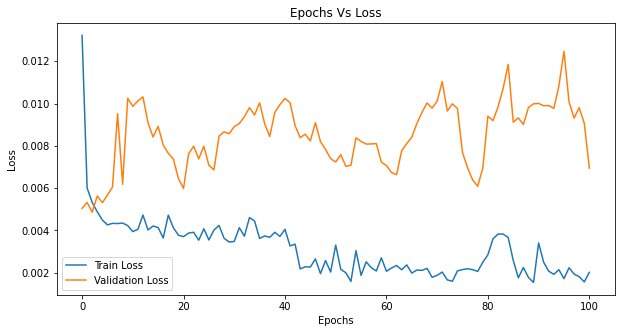

In [ ]:


plot_loss(train_CNN_loss , val_loss)

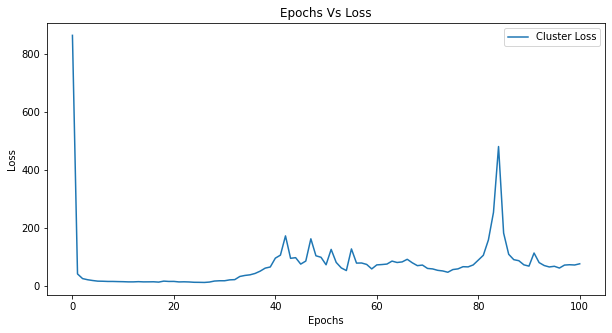

In [ ]:
def plot_cluster_loss( cluster_loss ):
    epochs = list( range(101) ) 
    plt.figure(figsize=(10,5))

    plt.plot(epochs, cluster_loss,label = "Cluster Loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.title('Epochs Vs Loss')
    
    plt.legend()
    
    plt.show()

plot_cluster_loss(train_CLuster_loss)

**Cluster Analysis & Testing**

In [ ]:
def plot_img(t):

    data , label = t
    print('Original Label :' + str(label) )
    img = data.numpy()

    op_img = np.zeros((224,224,3))
    op_img.shape

    for i in range(224):
        for j in range(224):
            col = [ img[0][i][j] , img[1][i][j] , img[2][i][j] ]

            op_img[i][j] = col 

    import matplotlib.pyplot as plt
    plt.imshow(op_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Label :1


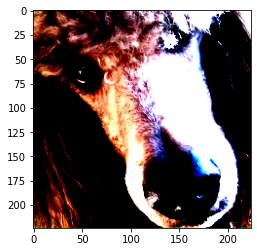

In [ ]:
plot_img( dataset[6000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Label :0


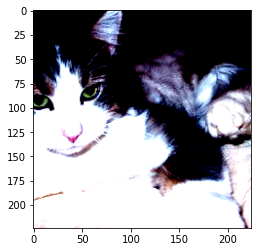

In [ ]:
plot_img(dataset[0])

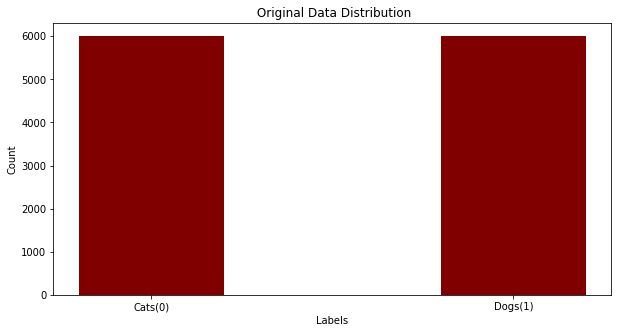

In [ ]:
cats , dogs = 0 ,0

for i in dataset:
    if i[1] == 0:
        cats += 1
    else:
        dogs += 1

labels = list( ['Cats(0)' ,'Dogs(1)'] )
values = list([cats ,dogs ])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='maroon', width = 0.4)
 
plt.title(' Original Data Distribution')
plt.xlabel("Labels")
plt.ylabel("Count")

plt.show()

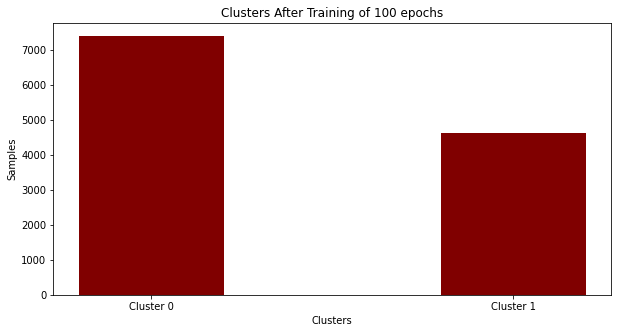

In [ ]:
### Deep cluster Distribution 
f = open('/content/drive/MyDrive/CV_project/clusters_list' , 'rb')
deepcluster = pickle.load(f)

clus0 = deepcluster.images_lists[0]
clus1 = deepcluster.images_lists[1]

labels = list( ['Cluster 0' , 'Cluster 1'] )
values = list([ len(clus0)  , len(clus1) ])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='maroon', width = 0.4)
 
plt.title('Clusters After Training of 100 epochs')
plt.xlabel("Clusters")
plt.ylabel("Samples")

plt.show()

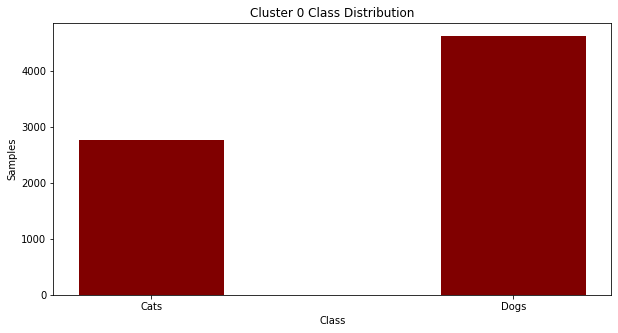

In [ ]:
#### Cluster 0 Analysis 

clus0_cat = 0
clus0_dog = 0

for idx in clus0:
    img ,label = dataset[idx]

    if label == 0 :
        clus0_cat += 1
    else:
        clus0_dog += 1

labels = list( ['Cats' , 'Dogs'] )
values = list([ clus0_cat , clus0_dog ])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='maroon', width = 0.4)
 
plt.title('Cluster 0 Class Distribution')
plt.xlabel("Class")
plt.ylabel("Samples")

plt.show()

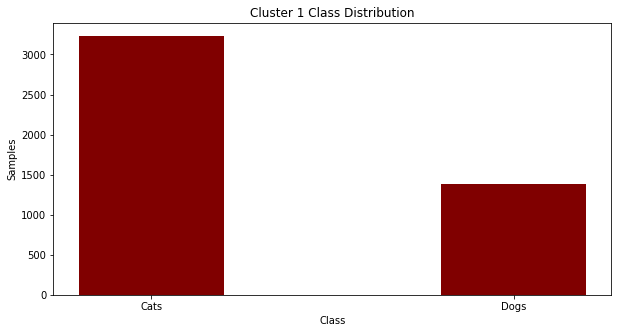

In [ ]:
#### Cluster 1 Analysis 

clus1_cat = 0
clus1_dog = 0

for idx in clus1:
    img ,label = dataset[idx]

    if label == 0 :
        clus1_cat += 1
    else:
        clus1_dog += 1

labels = list( ['Cats' , 'Dogs'] )
values = list([ clus1_cat , clus1_dog ])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='maroon', width = 0.4)
 
plt.title('Cluster 1 Class Distribution')
plt.xlabel("Class")
plt.ylabel("Samples")

plt.show()

**Cluster 0 :** 



*   Cluster 0 Distribution is Dominated By Dog Class
*   So , Considering Cluster 0 Representing Dog class 

**Cluster 1 :** 



*   Cluster 1 Distribution is Dominated By Cat Class
*   So , Considering Cluster 1 Representing Cat class





**Test**

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

tra = [transforms.Resize(256),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           normalize]

test_set = datasets.ImageFolder('/content/drive/MyDrive/CV_project/Test', transform=transforms.Compose(tra))

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=1,
                                          num_workers=2,
                                          pin_memory=True)

In [ ]:
f = open('/content/drive/MyDrive/CV_project/model_100' , 'rb')
final_model = pickle.load(f)



In [ ]:
import torch.nn.functional as F

final_model.eval()

preds = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        preds = final_model(data)
        
        probs = torch.exp(preds).cuda()
        prob = list(probs.numpy())

        prediction = np.argmax(prob, axis=1)
        
        preds.append(prediction)

In [ ]:
### 0 - Cats
### 1 - Dogs
### So Convert to 1-cats , 0-dogs 


orig_labels = []
zero , one = 0 ,0

for i in test_set:
    orig_labels.append(1 - i[1])

In [ ]:
from sklearn.metrics import accuracy_score

print('Accuracy Score :' + str(accuracy_score(preds , orig_labels) ) )

Accuracy Score :0.38461538461538464


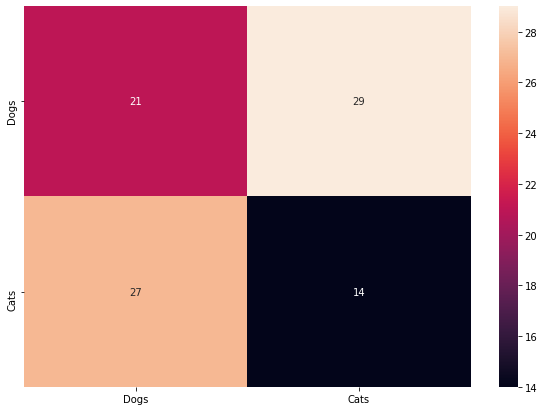

In [ ]:
import pandas as pd 
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_mat = confusion_matrix(orig_labels, preds)

df_cm = pd.DataFrame(confusion_mat, index = ['Dogs' , 'Cats'],columns = ['Dogs' ,'Cats'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
cats_orig = []
dogs_orig = []

incorrect_cats = []
incorrect_dogs = []

for i in range(len(pred)):

    if orig_labels[i] == pred[i] and orig_labesl[i] == 1:
        cats_orig.append(i)
    
    if orig_labels[i] == pred[i] and orig_labesl[i] == 0:
        dogs_orig.append(i)
    
    if orig_labels[i] != pred[i] and pred[i] == 1:
        incorrect_cats.append(i)
    
    if orig_labels[i] != pred[i] and pred[i] == 0:
        incorrect_dogs.append(i)

In [ ]:
def plot_correct(img_list,test_set):
    final_img = []

    for i in img_list:

        data , label = test_set[i]
        
        img = data.numpy()

        op_img = np.zeros((224,224,3))
        op_img.shape

        for i in range(224):
            for j in range(224):
                col = [ img[0][i][j] , img[1][i][j] , img[2][i][j] ]

                op_img[i][j] = col 
        
        final_img.append(op_img)

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
   
    f, axarr = plt.subplots(1,4 ,figsize=(10,10))
    
    axarr[0].imshow(final_img[0])
    axarr[1].imshow(final_img[1])
    axarr[2].imshow(final_img[2])
    axarr[3].imshow(final_img[3])

Original Label Cats


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


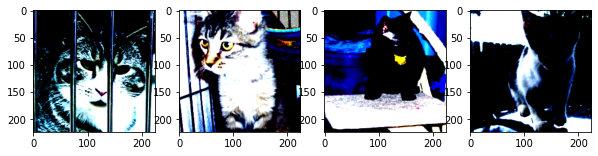

In [ ]:
print('Original Label Cats')
plot_correct( cats_orig[:4] , test_set)

Original Label Dogs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


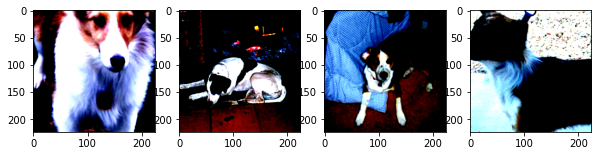

In [ ]:
print('Original Label Dogs')
plot_correct( dogs_orig[:4] , test_set)

Incorrect labels Cats


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


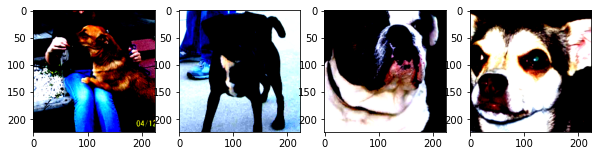

In [ ]:
print('Incorrect predicted Cats')
plot_correct( incorrect_cats[:4] , test_set)

Incorrect Label Dogs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


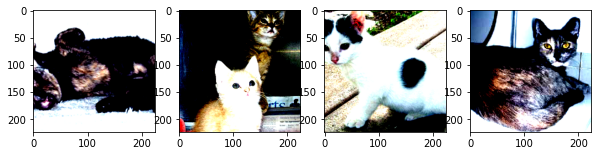

In [ ]:
print('Incorrect Predicted Dogs')
plot_correct( incorrect_dogs[:4] , test_set)